In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower
from tqdm.notebook import tqdm
import corner
import sys, platform, os
import time
camb.__version__,os.path.dirname(camb.__file__)

('1.3.6', 'C:\\Users\\miara\\anaconda3\\lib\\site-packages\\camb')

In [2]:
data = np.loadtxt('mcmc/COM_PowerSpect_CMB-TT-full_R3.01.txt')

In [3]:
np.shape(data)

(2507, 4)

In [4]:
l = data[:,0]
var = data[:,1]
varerr = 1/2*(data[:,2]+data[:,3])
N = np.diag(varerr**2)
Ninv = np.linalg.inv(N)

<IPython.core.display.Javascript object>


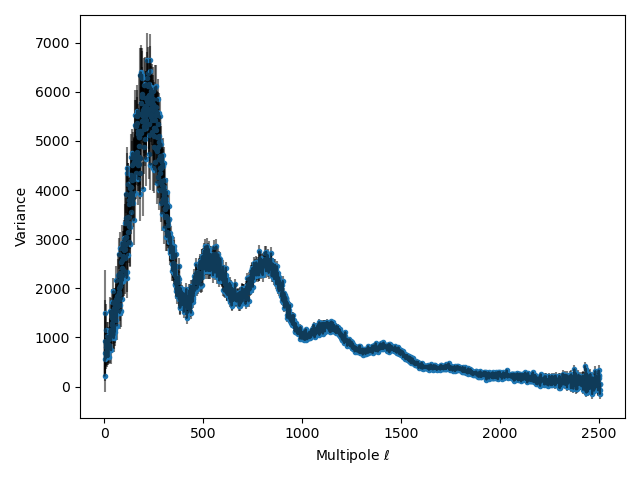

In [5]:
fig, ax = plt.subplots()
ax.plot(l,var,'.')
ax.errorbar(l,var,varerr,color = 'k',alpha = 0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel('Variance')
fig.tight_layout()

In [6]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
powers = powers['total'][:,0]

<IPython.core.display.Javascript object>


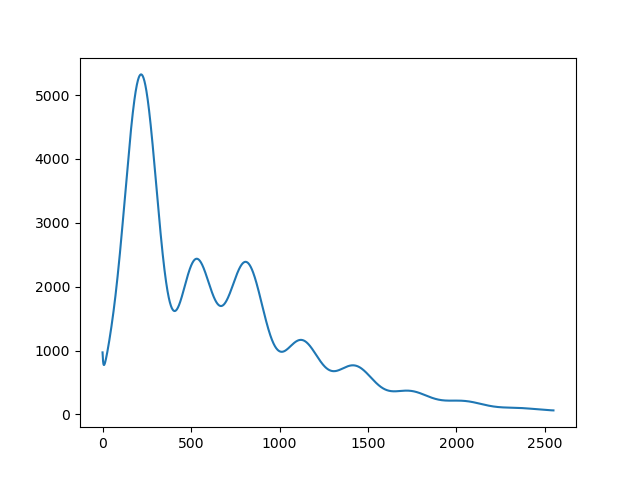

In [7]:
fig, ax = plt.subplots()
ax.plot(powers[2:])

chisq is  15267.937150261654  for  2501  degrees of freedom.


<IPython.core.display.Javascript object>


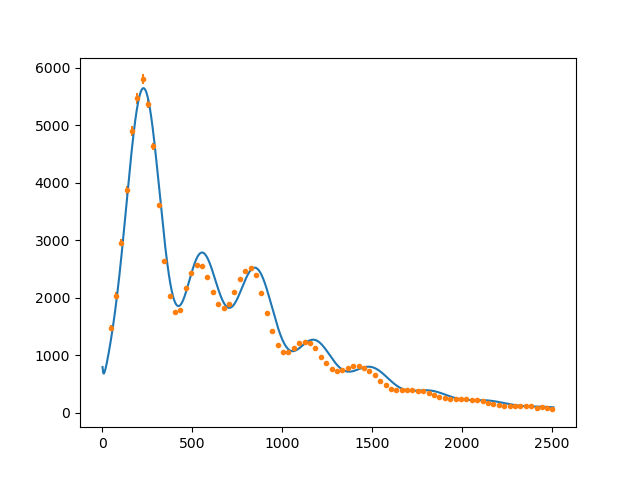

<ErrorbarContainer object of 3 artists>

In [9]:
def get_spectrum(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2:]


plt.ion()

pars=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
planck=np.loadtxt('mcmc/COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3]);
model=get_spectrum(pars)
model=model[:len(spec)]
def get_chisq(fun,data,pars,err):
    model=get_spectrum(pars)
    model=model[:len(data)]
    resid=spec-model
    chisq=np.sum( (resid/errs)**2)
    return chisq

chisq = get_chisq(get_spectrum,spec,pars,varerr)

print("chisq is ",chisq," for ",len(spec)-len(pars)," degrees of freedom.")
#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('mcmc/COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
fig,ax = plt.subplots()
ax.plot(ell,model)
ax.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')


In [15]:
def ndiff_multi(fun,p,lmax=3000):
    fun0 = fun(p,lmax)
    ef = 1e-16   
    dps = ef**(1/3)*np.abs(p) # computing the optimal dps
    #the following code adds the dp corresponding to each parameter and evaluates the function at the new location
    #in parameter space, then it computes the derivative, and repeats it for all parameters in fun
    dps = np.diag(dps) 
    grad = np.zeros([len(fun0),p.size])
    for i in tqdm(range(len(p)),leave = False):
        grad[:,i] = (fun(p+dps[i],lmax)-fun0)/dps[i][i]
    return fun0,grad

In [16]:
pars =  np.asarray([69, 0.022, 0.12,0.06, 2.1e-9, 0.95])
chisq = get_chisq(get_spectrum,spec,pars,varerr)
print("chisq is ",chisq," for ",len(spec)-len(pars)," degrees of freedom.")

chisq is  3272.2053559202204  for  2501  degrees of freedom.


In [12]:
def calc_spectrum(p):
    y,grad = ndiff_multi(get_spectrum,p)
    return y,grad


iter = 5
p0=np.asarray([69, 0.022, 0.12,0.06, 2.1e-9, 0.95])
p=p0.copy()
chisqs = np.zeros(iter+1)
chisqs[0] = get_chisq(get_spectrum,spec,p0,varerr)
errprev = 0
err = np.inf
for i in tqdm(range(iter)):
    errprev = err
    pred,grad=calc_spectrum(p)
    pred,grad = pred[:len(spec)],grad[:len(spec)]
    resid=spec-pred
    r=resid.T
    lhs=grad.T@Ninv@grad
    rhs=grad.T@Ninv@r
    try:
        cov = np.linalg.inv(lhs)
    except:
        cov = np.linalg.pinv(lhs)
    dp=cov@rhs
    for ii in range(p.size):
        p[ii]=p[ii]+dp[ii]  
    chisq=np.sum((resid/varerr)**2)
    chisqs[i+1] = chisq

<IPython.core.display.Javascript object>


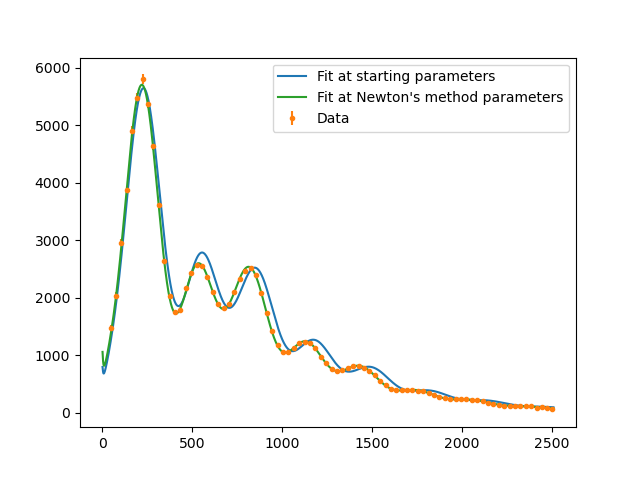

chisq is  2576.3052119680515  for  2501  degrees of freedom.


In [13]:
fig,ax = plt.subplots()
ax.plot(ell,model,label = 'Fit at starting parameters')
ax.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.',label = 'Data')
model2=get_spectrum(p)
model2=model2[:len(spec)]
ax.plot(ell,model2,label = 'Fit at Newton\'s method parameters')
ax.legend()
noise = np.mean(np.abs(model2-spec))
chisq = get_chisq(get_spectrum,spec,p,varerr)
print("chisq is ",chisq," for ",len(spec)-len(pars)," degrees of freedom.")

In [17]:
def get_step(pars,cov,scale):
    return np.random.multivariate_normal(np.zeros(len(pars)),cov)*scale

def run_chain(fun,pars,err,cov,data,scale,nstep=20000,T=1):
    accepted = 0
    npar=len(pars)
    chain=np.zeros([nstep,npar+1])
    chain[0,:-1]=pars
    chi_cur=get_chisq(fun,data,pars,err)
    chain[0][-1]=chi_cur
    for i in tqdm(range(1,nstep)):
        pp=pars+get_step(pars,cov,scale)
        new_chisq=get_chisq(fun,data,pp,err)
        accept_prob=np.exp(-0.5*(new_chisq-chi_cur)/T)
        if np.random.rand(1)<accept_prob:
            accepted+=1
            pars=pp
            chi_cur=new_chisq
        chain[i,:-1]=pars
        chain[i][-1]=chi_cur
        path = 'Chains/planck_chain_{}.txt'.format(nstep)
        np.savetxt(path,chain)
    accrate = accepted/nstep
    chisq = chain[:,-1]
    chain = chain[:,:-1]
    return chain,chisq,accrate

In [18]:
chain,chisq,accrate = run_chain(get_spectrum,p,varerr,cov,spec,scale = 1,nstep = 1200)

In [31]:
chainload = np.loadtxt('Chains/planck_chain.txt'.format(1200))
params = [r'$H_0$',r'$\Omega_bh^2$',r'$\Omega_ch^2$',r'$\tau$',r'$A_s$',r'$n_s$']

<IPython.core.display.Javascript object>


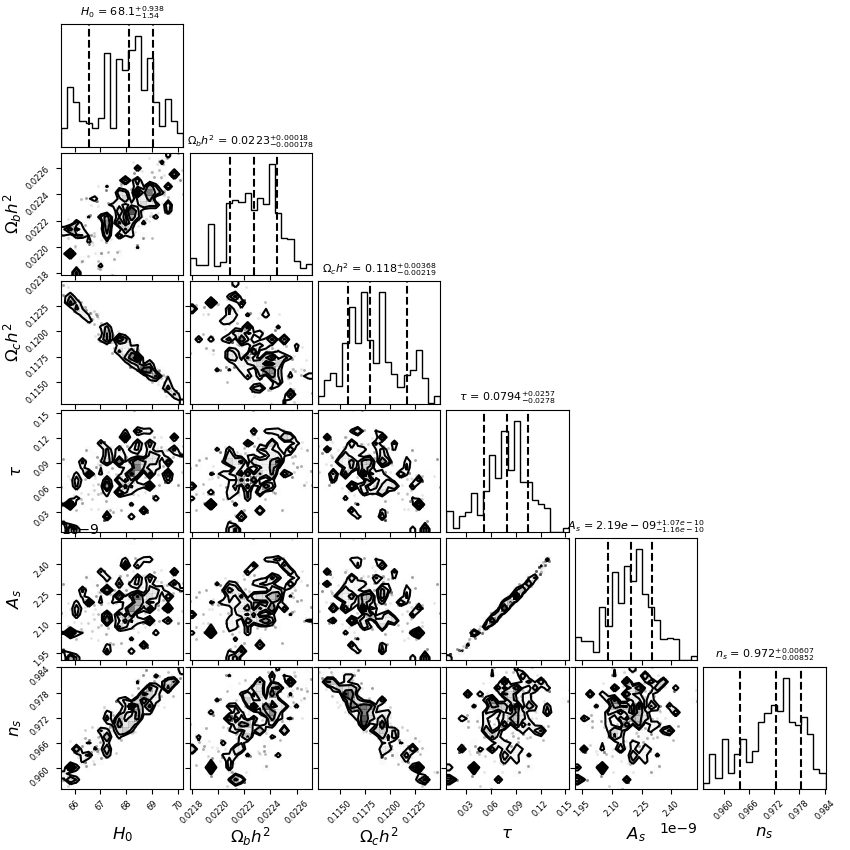

In [38]:
fig = corner.corner(chain,labels = params,label_kwargs=dict(fontsize=12),
                    quantiles = [0.16,.5,.84],show_titles=True,title_fmt='.3g',title_kwargs = dict(fontsize = 8))
fig.set_size_inches((8.5,8.5))
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=6)

<IPython.core.display.Javascript object>


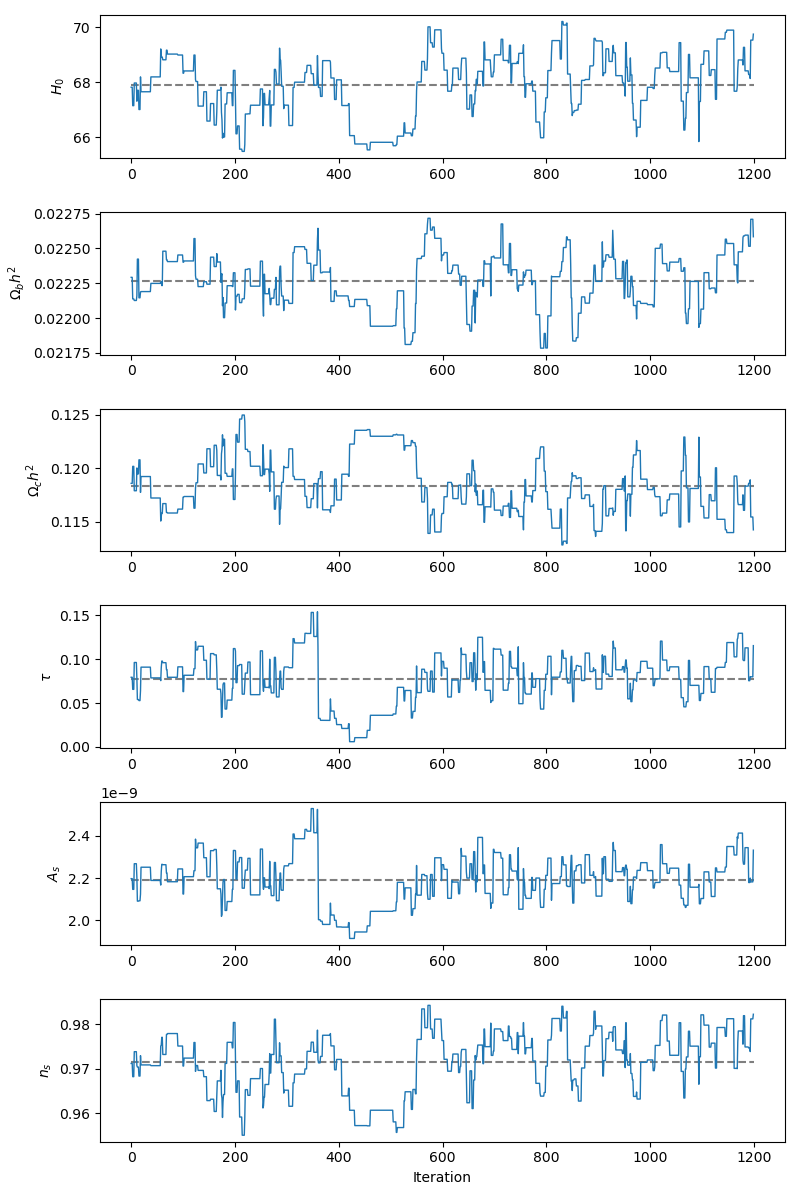

In [51]:
pmcmc = np.mean(chain,axis = 0)
pmcmc_err = np.std(chain,axis = 0)

fig,ax = plt.subplots(np.shape(chain)[1],1,figsize = (8,2*np.shape(chain)[1]))
for i in range(np.shape(chain)[1]):
    ax[i].plot(chain[:,i],linewidth = 1)
    ax[i].set_ylabel(params[i])
    ax[i].hlines(pmcmc[i],0,len(chain),linestyle = '--',alpha = 0.5,zorder = -1)
ax[-1].set_xlabel('Iteration')
fig.tight_layout()